##Recognizing ASL Fingerspelling Using Machine Learning
####Dataset Name: ASL Alphabet
####[Kaggle Data Soruce](https://www.kaggle.com/datasets/grassknoted/asl-alphabet)
####Goal: Develop a machine learning model to recognize ASL fingerspelling from images.
The dataset consists of images of American Sign Language fingerspelling. Each image represents a different letter of the alphabet. Our goal is to build a machine learning model that can correctly identify and classify these hand signs based on visual input.
The dataset contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for space, delete and nothing.

In [148]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [150]:
dataset_path = "./asl_alphabet_train"

In [152]:
all_classes = sorted([os.path.basename(folder) for folder in glob.glob(os.path.join(dataset_path, "*"))])
print(f"Total Dataset Classes: {len(all_classes)}")
print("Dataset Classes:", all_classes)

asl_keep = ["A", "B", "C", "D", "E", "F", "H", "I", "L", "O", "Q", "R", "S", "U", "V", "W", "X", "Y"]
print(f"\nSelected ASL Letters ({len(asl_keep)}): {asl_keep}")

Total Dataset Classes: 29
Dataset Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Selected ASL Letters (18): ['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'L', 'O', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']


In [154]:
asl_paths_train = []
for letter in asl_keep:
    letter_path = os.path.join(dataset_path, letter)
    letter_images = glob.glob(os.path.join(letter_path, "*.jpg"))
    asl_paths_train.extend(letter_images[:500])
    
asl_labels_train = [os.path.basename(os.path.dirname(img)) for img in asl_paths_train]

train_asl_df = pd.DataFrame({"image_path": asl_paths_train, "letter_label": asl_labels_train})

print(f"\nTotal images loaded: {len(train_asl_df)}")
class_distribution = train_asl_df['letter_label'].value_counts()
print("\nImages per class:")
print(class_distribution)


Total images loaded: 9000

Images per class:
letter_label
A    500
B    500
X    500
W    500
V    500
U    500
S    500
R    500
Q    500
O    500
L    500
I    500
H    500
F    500
E    500
D    500
C    500
Y    500
Name: count, dtype: int64


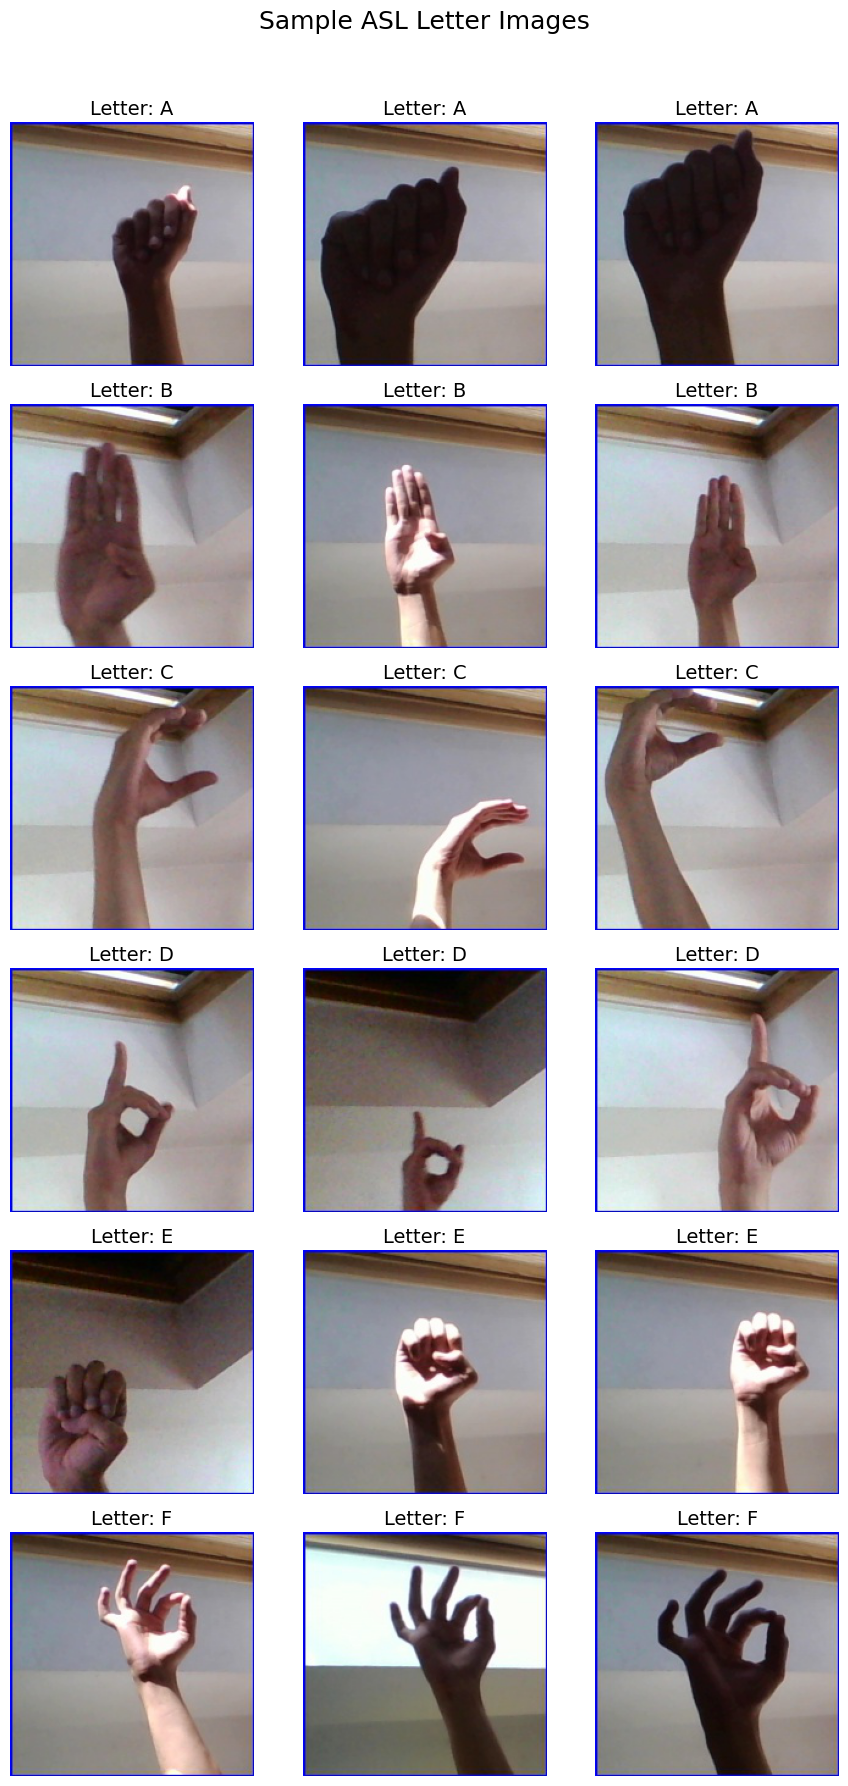

In [156]:
def plot_sample_images(letters=asl_keep[:9], samples_per_letter=3):
    rows = len(letters)
    cols = samples_per_letter
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    
    for i, letter in enumerate(letters):
        letter_samples = train_asl_df[train_asl_df['letter_label'] == letter].sample(samples_per_letter)
        
        for j, (_, row) in enumerate(letter_samples.iterrows()):
            img = plt.imread(row['image_path'])
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"Letter: {letter}", fontsize=14)
            axes[i, j].axis('off')
            
            for spine in axes[i, j].spines.values():
                spine.set_visible(True)
                spine.set_color('gray')
                spine.set_linewidth(0.5)
    
    plt.suptitle("Sample ASL Letter Images", fontsize=18, y=0.99)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

plot_sample_images(letters=asl_keep[:6], samples_per_letter=3)

K-Means Clustering

In [159]:
sample_size_per_class = 50 
sampled_df = pd.DataFrame()

for letter in asl_keep:
    letter_df = train_asl_df[train_asl_df['letter_label'] == letter]
    letter_sample = letter_df.sample(sample_size_per_class)
    sampled_df = pd.concat([sampled_df, letter_sample])

sampled_df = sampled_df.reset_index(drop=True)

X_sample = []
for img_path in sampled_df['image_path']:
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (64, 64))
    X_sample.append(img_resized)

X_sample = np.array(X_sample)
y_sample = sampled_df['letter_label'].values

X = X_sample.reshape(len(X_sample), -1)
X = X.astype(float) / 255.  

print("Array Shape:", X.shape)

n_groups = len(asl_keep)  
print("Number of Groups:", n_groups)

Array Shape: (900, 12288)
Number of Groups: 18


In [161]:
kmeans = KMeans(n_clusters=n_groups, 
                n_init=50,  
                random_state=42)
kmeans.fit(X)

kmeans_labs = kmeans.labels_
X_distance = kmeans.transform(X)

rep_letter_index = np.argmin(X_distance, axis=0)

X_rep_letters = X_sample[rep_letter_index]
y_rep_letters = y_sample[rep_letter_index]

print("Silhouette Score:", silhouette_score(X, kmeans_labs))

Silhouette Score: 0.18324945386237826


K-Means Centroid ASL Letter Images:
----------------------------------------------


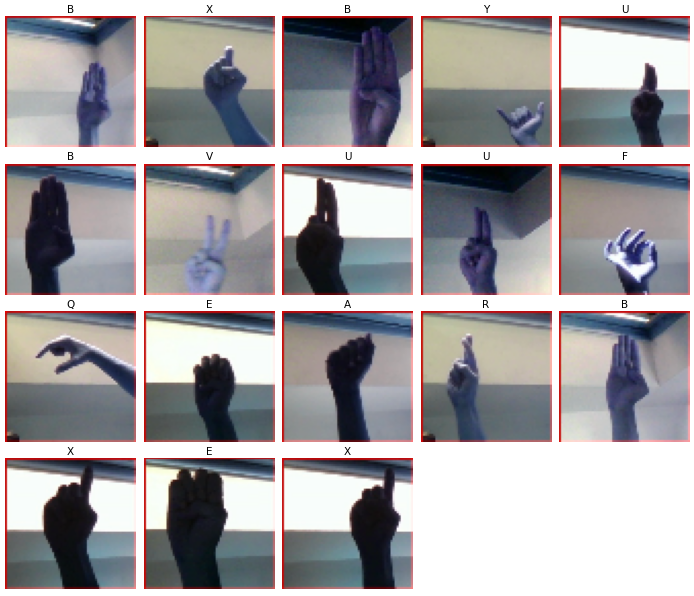

In [163]:
rows = int(np.ceil(n_groups / 5))
cols = min(5, n_groups)

fig1, ax1 = plt.subplots(rows, cols, figsize=(14, rows * 3), dpi=50)
ax1 = ax1.flatten()

for i in range(n_groups):
    im = ax1[i].imshow(X_rep_letters[i])
    lab = y_rep_letters[i]
    ax1[i].set_title(f"{lab}", fontsize=15)
    ax1[i].axis('off')

for j in range(n_groups, len(ax1)):
    ax1[j].axis('off')

print("K-Means Centroid ASL Letter Images:\n----------------------------------------------")
plt.tight_layout()
plt.show()


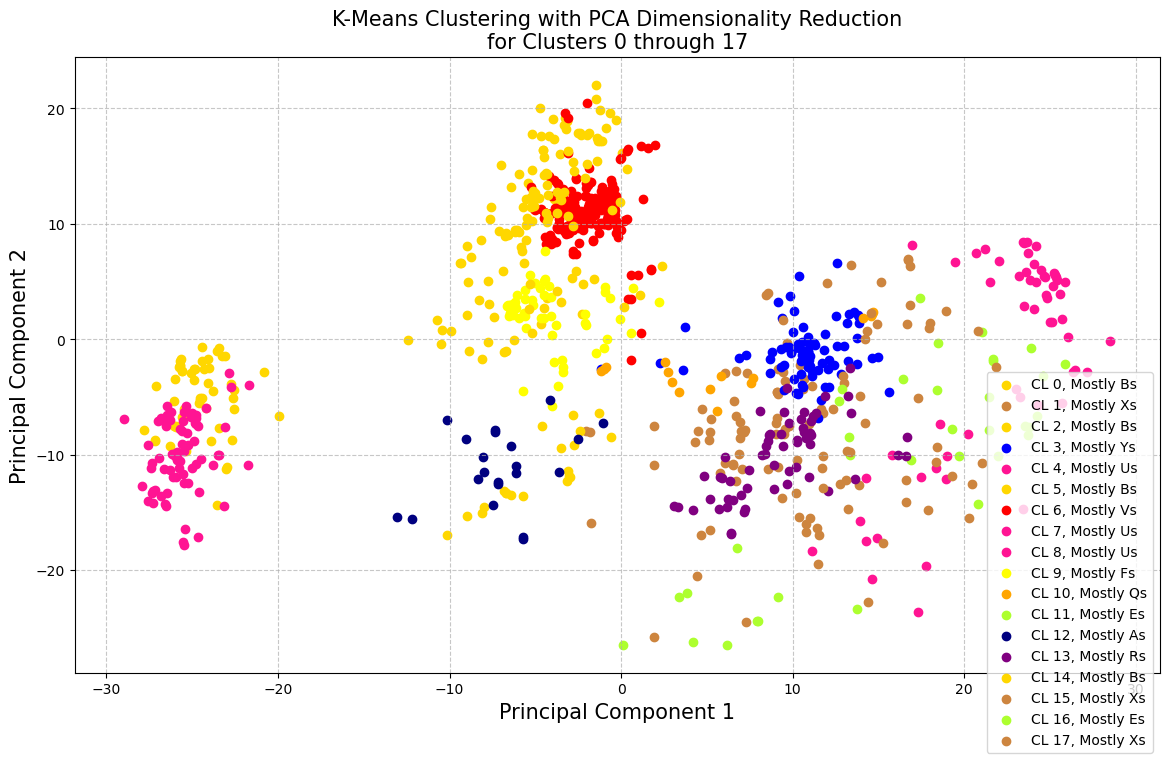

In [165]:
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

letter_colormap = ['red', 'gold', 'darkred', 'yellow', 'orange', 'greenyellow', 
                  'peru', 'purple', 'deeppink', 'blue', 'cyan', 'magenta',
                  'brown', 'olive', 'navy', 'teal', 'coral', 'silver']

if len(letter_colormap) < len(asl_keep):
    letter_colormap = plt.cm.tab20(np.linspace(0, 1, len(asl_keep)))

unique_letters = list(set(y_sample))
color_mapping = pd.DataFrame({
    'color': letter_colormap[:len(unique_letters)],
    'letter_label': unique_letters
})

pca_colormap = []
for letter in y_rep_letters:
    assigned_color = color_mapping[color_mapping['letter_label'] == letter].iloc[0, 0]
    pca_colormap.append(assigned_color)

plt.figure(figsize=(14, 8))

for i in range(n_groups):
    plt.scatter(
        X_pca[kmeans_labs == i, 0],
        X_pca[kmeans_labs == i, 1],
        label=f'CL {i}, Mostly {y_sample[rep_letter_index[i]]}s',
        color=pca_colormap[i]
    )

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title(f'K-Means Clustering with PCA Dimensionality Reduction\nfor Clusters 0 through {n_groups-1}',
          fontsize=15)
plt.xlabel('Principal Component 1', fontsize=15)
plt.ylabel('Principal Component 2', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

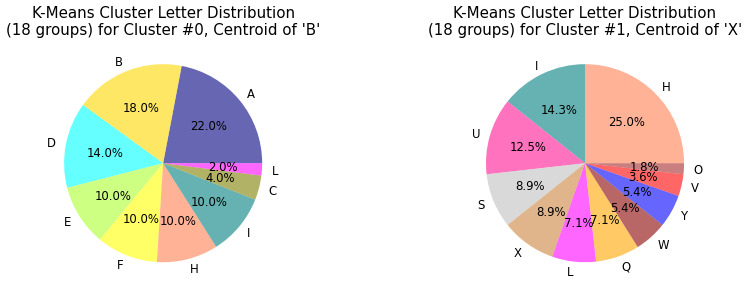

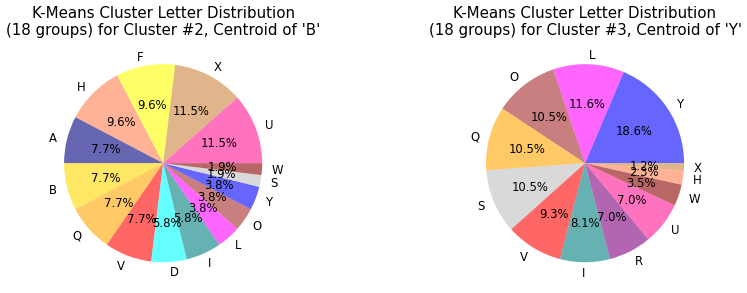

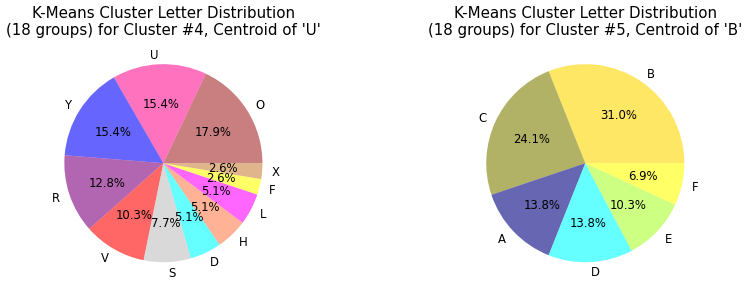

In [167]:
def plot_cluster_results(cluster_num_1, cluster_num_2):
    sample_data_kmeans_labs = pd.DataFrame({'letter_label': y_sample})
    sample_data_kmeans_labs['kmeans_lab'] = kmeans_labs
    
    cluster_1_values = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster_num_1]['letter_label'].value_counts()
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 5), dpi=60)
    
    pie_1_colors = []
    for letter in cluster_1_values.index:
        color_row = color_mapping[color_mapping['letter_label'] == letter]
        if not color_row.empty:
            pie_1_colors.append(color_row.iloc[0, 0])
        else:
            pie_1_colors.append('gray')
    
    axs[0].pie(cluster_1_values.values, labels=cluster_1_values.index, 
               autopct='%1.1f%%', colors=pie_1_colors, 
               wedgeprops={"alpha": 0.6}, textprops={'fontsize': 14})
    
    axs[0].set_title(f'K-Means Cluster Letter Distribution\n({n_groups} groups) for Cluster #{cluster_num_1}, Centroid of \'{y_sample[rep_letter_index[cluster_num_1]]}\'',
                     fontsize=18)
    
    cluster_2_values = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster_num_2]['letter_label'].value_counts()
    
    pie_2_colors = []
    for letter in cluster_2_values.index:
        color_row = color_mapping[color_mapping['letter_label'] == letter]
        if not color_row.empty:
            pie_2_colors.append(color_row.iloc[0, 0])
        else:
            pie_2_colors.append('gray')
    
    axs[1].pie(cluster_2_values.values, labels=cluster_2_values.index, 
               autopct='%1.1f%%', colors=pie_2_colors, 
               wedgeprops={"alpha": 0.6}, textprops={'fontsize': 14})
    
    axs[1].set_title(f'K-Means Cluster Letter Distribution\n({n_groups} groups) for Cluster #{cluster_num_2}, Centroid of \'{y_sample[rep_letter_index[cluster_num_2]]}\'',
                     fontsize=18)
    
    plt.tight_layout()
    plt.show()

plot_cluster_results(0, 1)
plot_cluster_results(2, 3)
plot_cluster_results(4, 5)

Visualizing high purity cluster 10 (purity: 0.94)


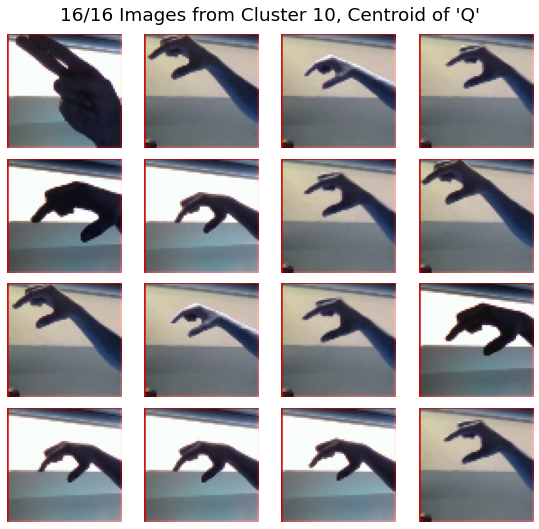

Visualizing low purity cluster 8 (purity: 0.11)


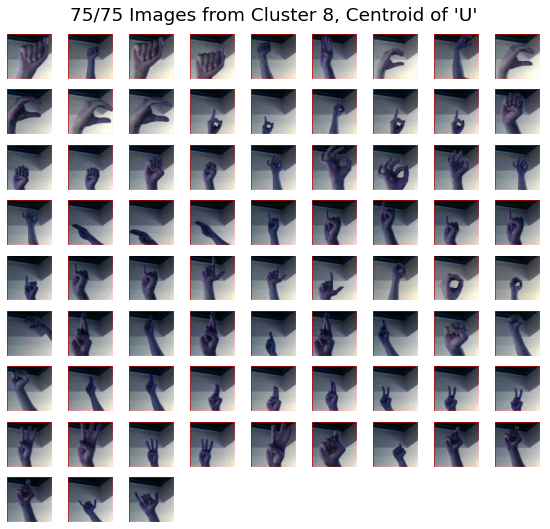

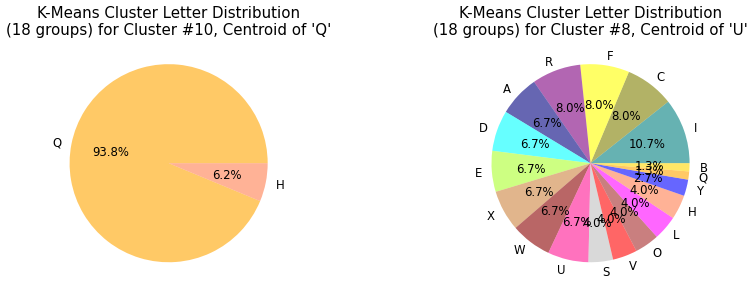

In [169]:
def plot_cluster_images(cluster_num):
    cluster_indices = np.where(kmeans_labs == cluster_num)[0]
    
    num_images = min(81, len(cluster_indices))
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))
    
    fig, ax = plt.subplots(rows, cols, figsize=(8, 8), dpi=70)
    ax = ax.flatten()
    
    centroid_letter = y_sample[rep_letter_index[cluster_num]]
    
    fig.suptitle(f"{num_images}/{len(cluster_indices)} Images from Cluster {cluster_num}, Centroid of \'{centroid_letter}\'", 
                 fontsize=19, y=0.94)
    
    for i in range(num_images):
        ax[i].imshow(X_sample[cluster_indices[i]])
        ax[i].axis('off')
    
    for i in range(num_images, len(ax)):
        ax[i].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

sample_data_kmeans_labs = pd.DataFrame({'letter_label': y_sample, 'kmeans_lab': kmeans_labs})

cluster_purity = {}
for cluster in range(n_groups):
    cluster_letters = sample_data_kmeans_labs[sample_data_kmeans_labs['kmeans_lab'] == cluster]['letter_label']
    if len(cluster_letters) > 0:
        most_common_letter = cluster_letters.value_counts().idxmax()
        purity = cluster_letters.value_counts().max() / len(cluster_letters)
        cluster_purity[cluster] = purity

sorted_clusters = sorted(cluster_purity.items(), key=lambda x: x[1], reverse=True)

high_purity_cluster = sorted_clusters[0][0]
low_purity_cluster = sorted_clusters[-1][0]

print(f"Visualizing high purity cluster {high_purity_cluster} (purity: {sorted_clusters[0][1]:.2f})")
plot_cluster_images(high_purity_cluster)

print(f"Visualizing low purity cluster {low_purity_cluster} (purity: {sorted_clusters[-1][1]:.2f})")
plot_cluster_images(low_purity_cluster)

plot_cluster_results(high_purity_cluster, low_purity_cluster)